**Q4:**

In [14]:
student_id =  402300459
student_name = "Mohammadreza Bagheri"

print("your student id:", student_id)
print("your name:", student_name)

your student id: 402300459
your name: Mohammadreza Bagheri


**Part A)**
# What is the advantage of VQ-VAE over traditional VAE?
*The main difference of VQ-VAE and VAE is that the latent space in is discrete. It leads to a more interpretable representations. In fact, each discrete code correspond to a specific set of features. This capability makes the representation and analysis of data much more easier.*

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Part B)**
In this part, we load MNIST dataset as our training data.

In [16]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = MNIST(root="./data", train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


**Part C)**
In this part, the main blocks of VQ-VAE are implemented:

In [32]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1) # first convolutional layer
        self.conv2 = nn.Conv2d(16, 2, kernel_size=3, stride=2, padding=1) # second convolutional layer


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(2, 16, kernel_size=4, stride=2, padding=1) # first deconvolutional layer
        self.conv2 = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)  # second deconvolutional layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        return x




class Codebook(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(Codebook, self).__init__()
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        flat_input = inputs.view(-1, self._embedding_dim)
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) # Encoding
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)


        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape) # Quantize and unflatten

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach() # due to stopping gradient in back prop.
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings




**Part D)**
In this part, the loss comoputing function is defined as a function of the input and recunstructed images and also encoder output and the codebook output.

In [18]:
def compute_loss(x, x_hat, loss_comm, beta):
    mseloss = nn.MSELoss()
    reconstruction_loss = mseloss(x_hat, x) # the error between input image and the reconstructed image
    loss = reconstruction_loss + loss_comm # total loss
    return loss

**Part E)**
Here, we train the model and plot the training figures.

In [44]:
latent_dim = 2
num_embeddings = 3
embedding_dim = 2
num_epochs = 5
beta = 0.2

encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
codebook = Codebook(num_embeddings, embedding_dim, 0.23)

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(codebook.parameters()), lr=0.1)

loss_arr = []

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    codebook.train()

    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)


        z_e = encoder(x)
        loss_comm, quantized, perplexity, _ = codebook(z_e.detach())
        x_hat = decoder(quantized)

        loss = compute_loss(x, x_hat, loss_comm, beta)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_arr.append(loss.item())
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}")

Epoch 1/5, Batch 0/938, Loss: 1.225365161895752
Epoch 1/5, Batch 100/938, Loss: 0.6657384634017944
Epoch 1/5, Batch 200/938, Loss: 0.7316449880599976
Epoch 1/5, Batch 300/938, Loss: 0.6991917490959167
Epoch 1/5, Batch 400/938, Loss: 0.7073153853416443
Epoch 1/5, Batch 500/938, Loss: 0.697666347026825
Epoch 1/5, Batch 600/938, Loss: 0.707795262336731
Epoch 1/5, Batch 700/938, Loss: 0.6951742172241211
Epoch 1/5, Batch 800/938, Loss: 0.6579679250717163
Epoch 1/5, Batch 900/938, Loss: 0.7048037052154541
Epoch 2/5, Batch 0/938, Loss: 0.6945441365242004
Epoch 2/5, Batch 100/938, Loss: 0.6836565136909485
Epoch 2/5, Batch 200/938, Loss: 0.6472290754318237
Epoch 2/5, Batch 300/938, Loss: 0.7161380648612976
Epoch 2/5, Batch 400/938, Loss: 0.6895149946212769
Epoch 2/5, Batch 500/938, Loss: 0.6940789222717285
Epoch 2/5, Batch 600/938, Loss: 0.6519849896430969
Epoch 2/5, Batch 700/938, Loss: 0.647187352180481
Epoch 2/5, Batch 800/938, Loss: 0.6565893292427063
Epoch 2/5, Batch 900/938, Loss: 0.63029

Here, we plot some outputs of the trained model:

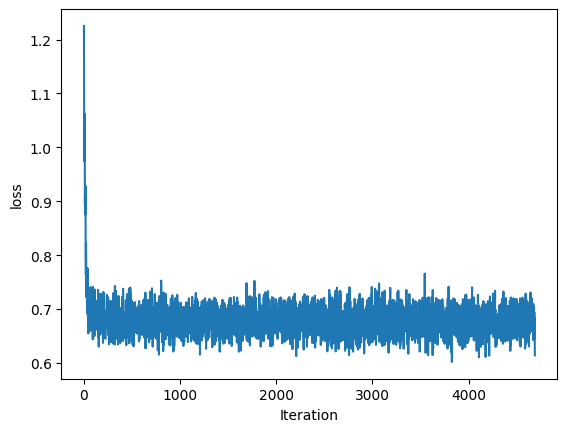

In [45]:
import matplotlib.pyplot as plt
plt.plot(loss_arr)
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.show()

torch.Size([1, 28, 28])


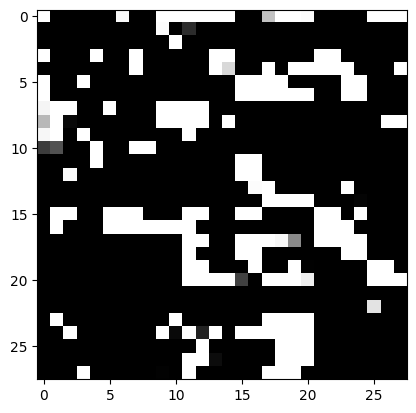

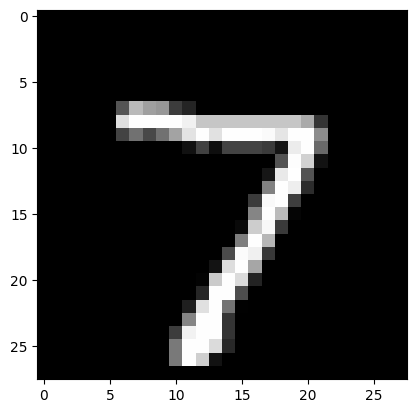

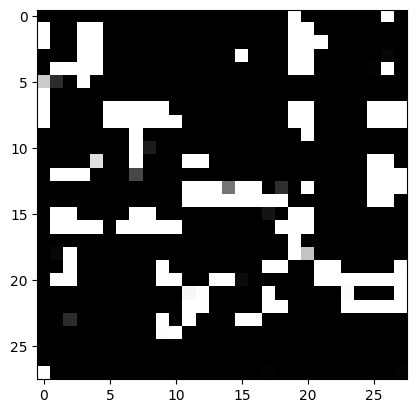

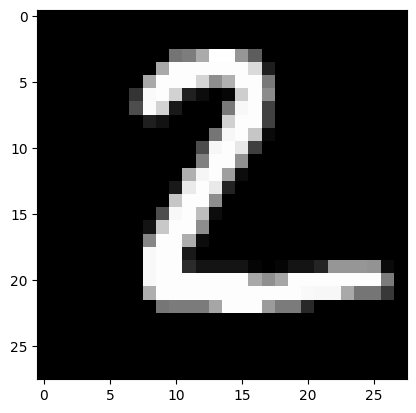

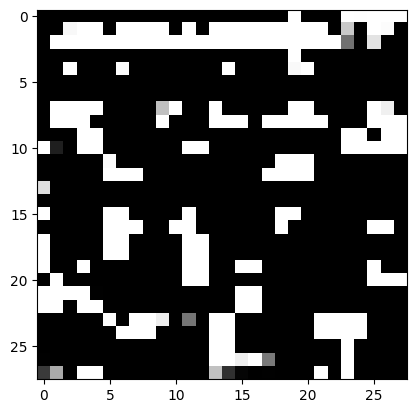

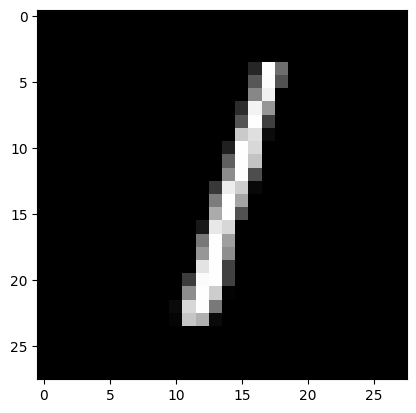

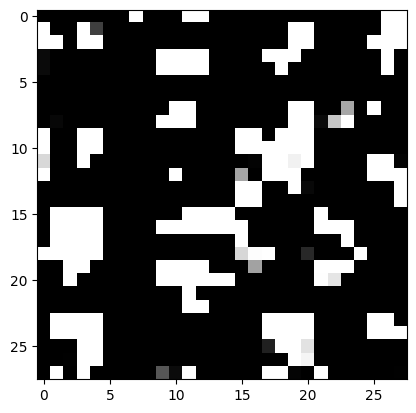

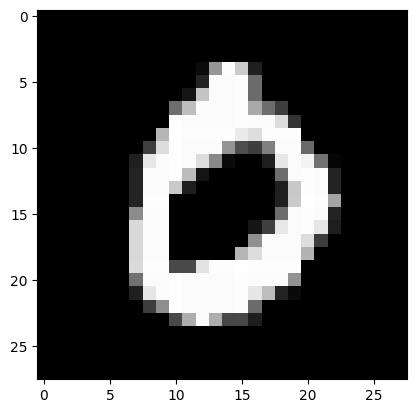

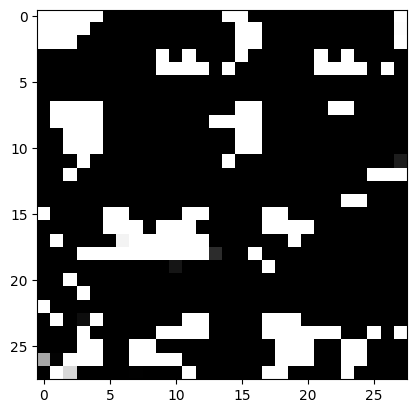

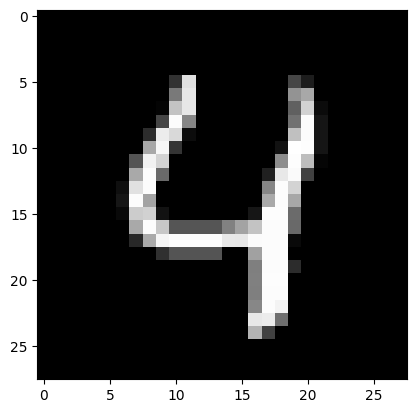

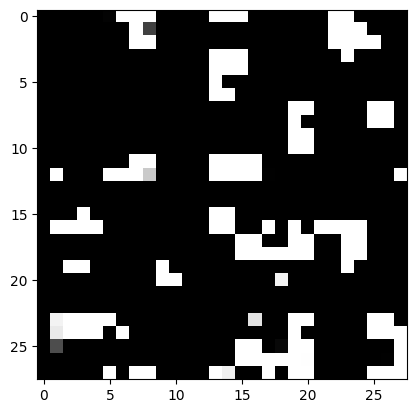

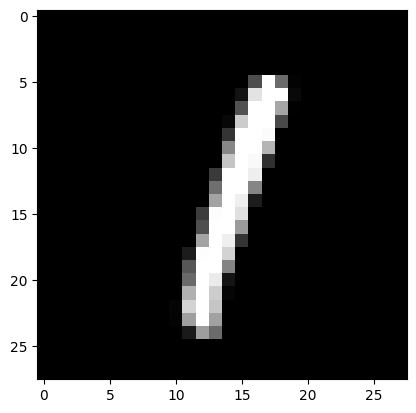

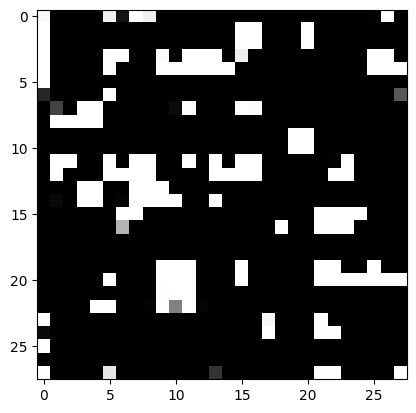

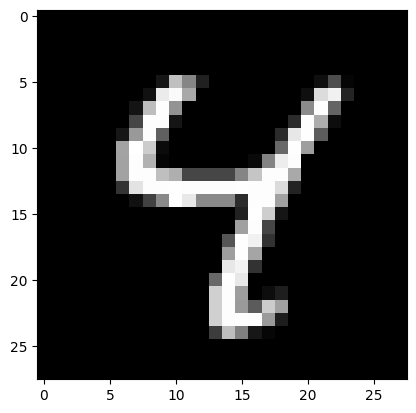

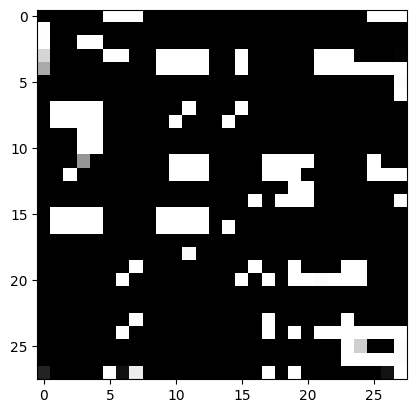

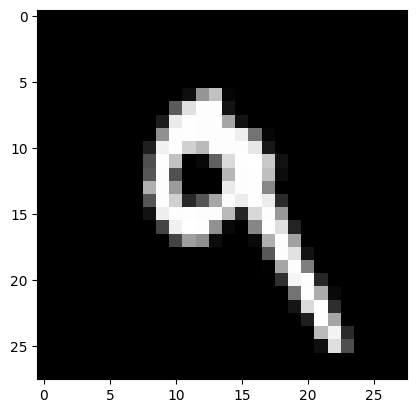

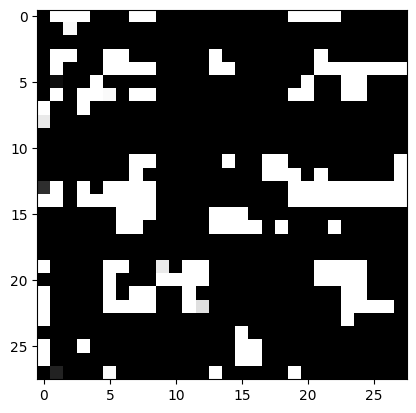

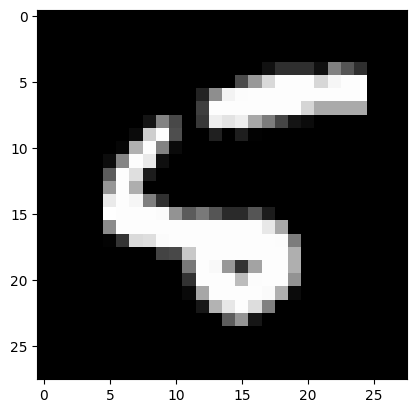

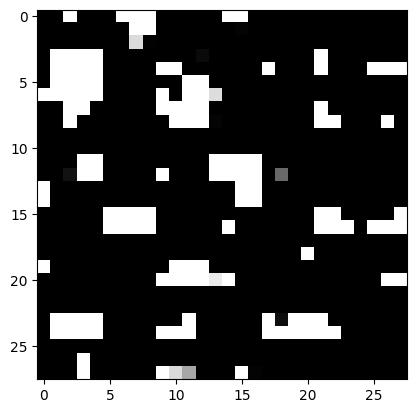

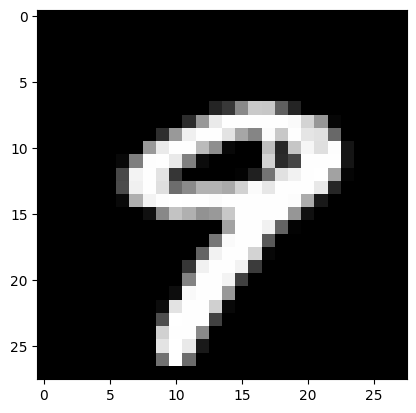

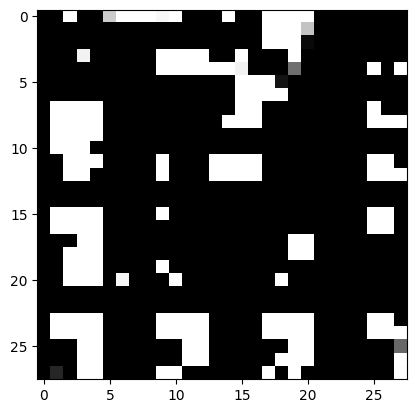

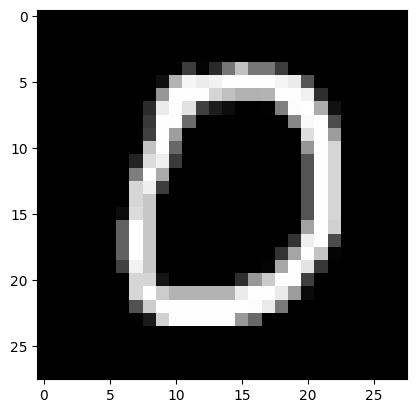

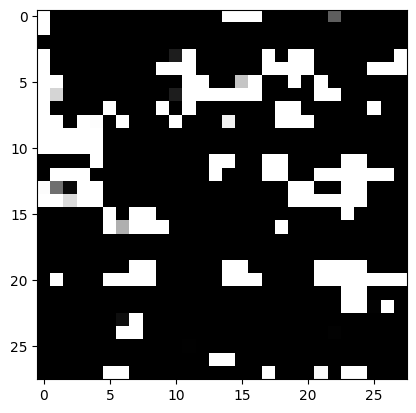

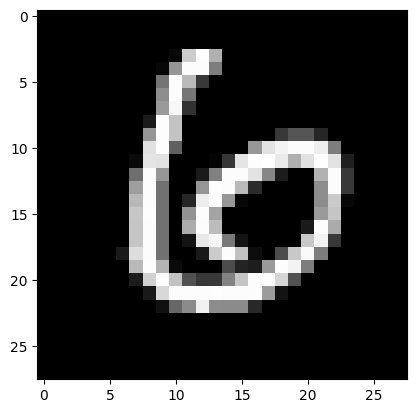

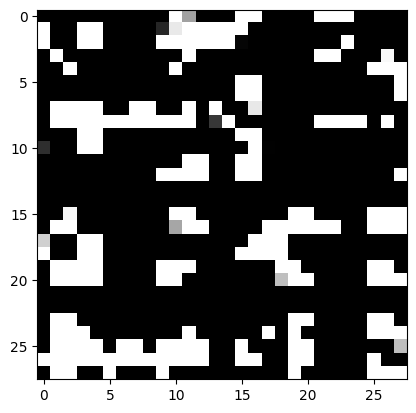

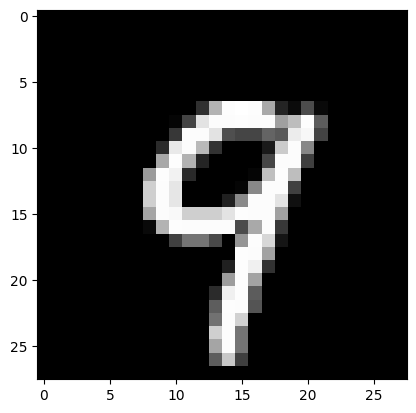

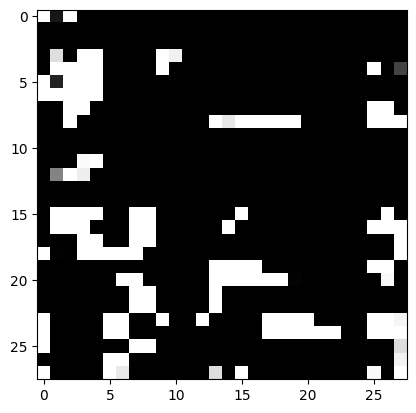

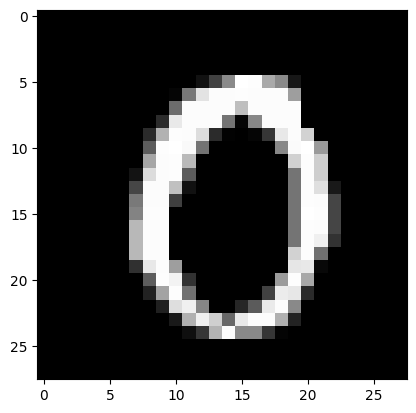

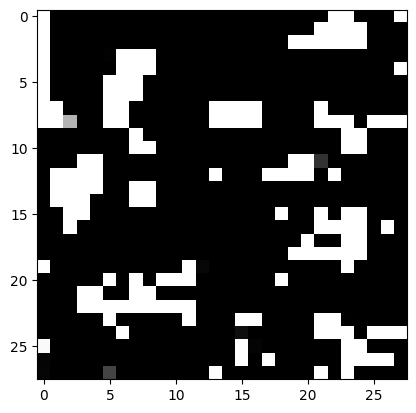

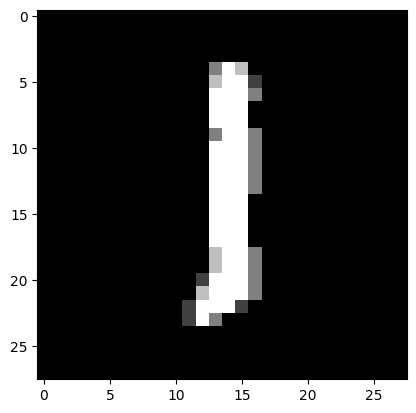

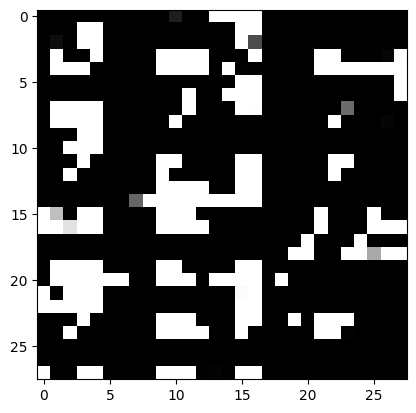

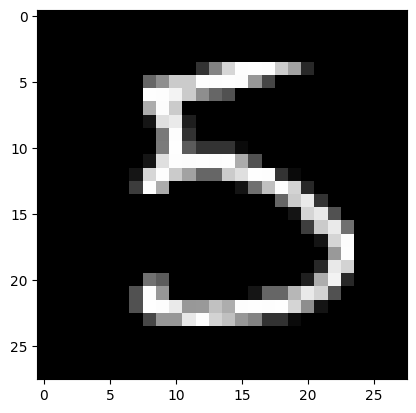

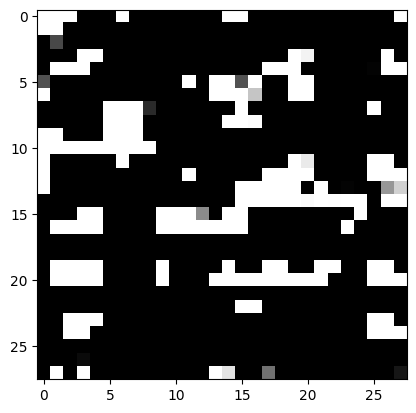

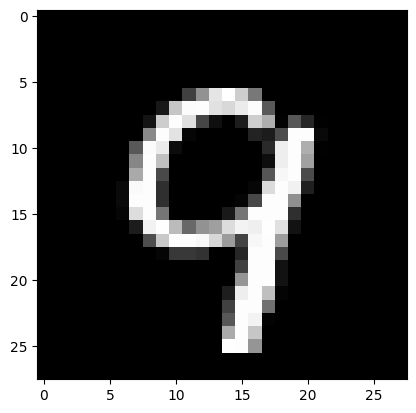

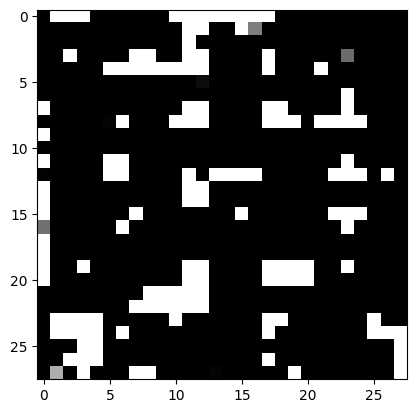

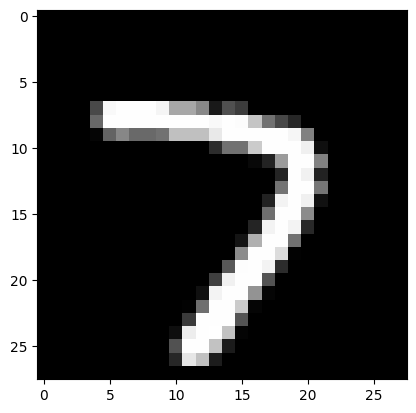

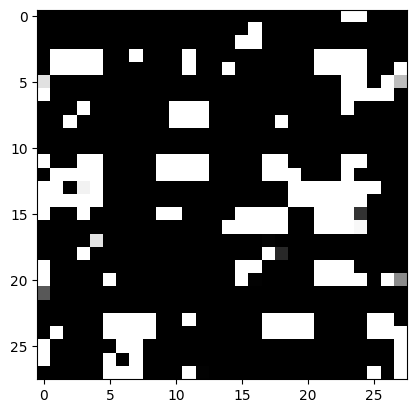

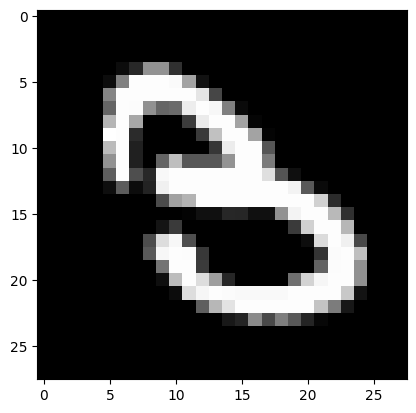

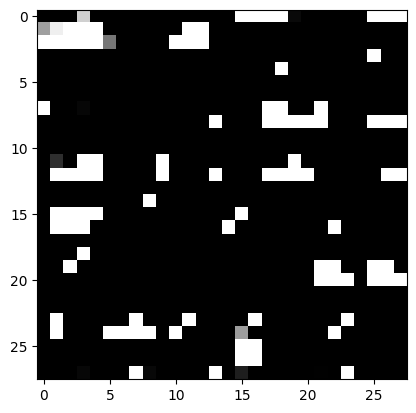

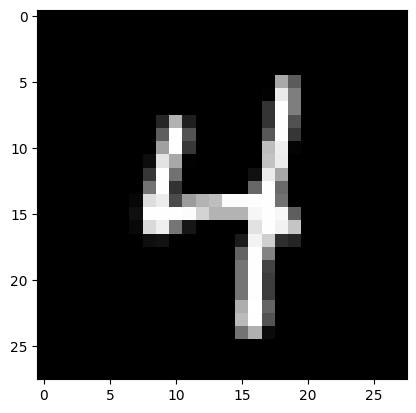

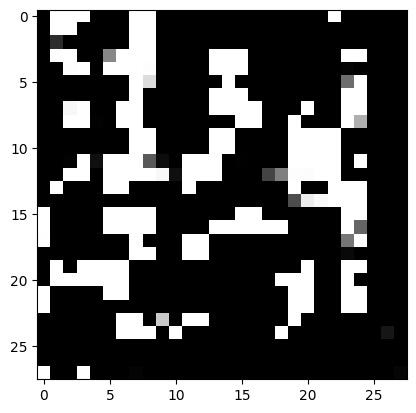

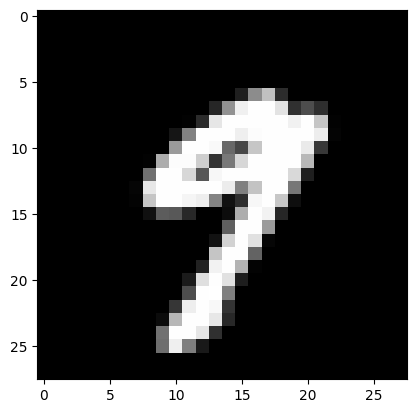

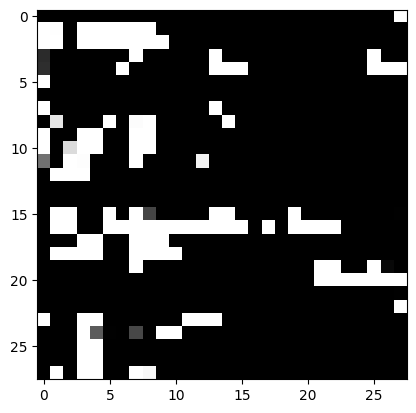

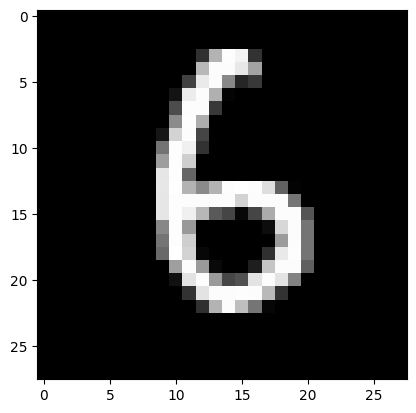

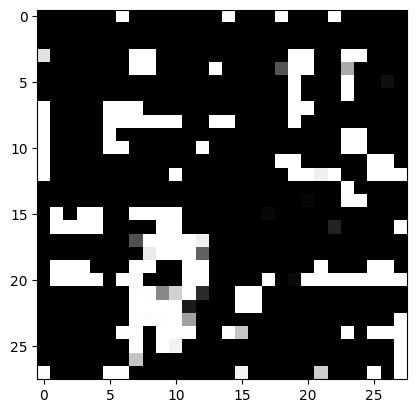

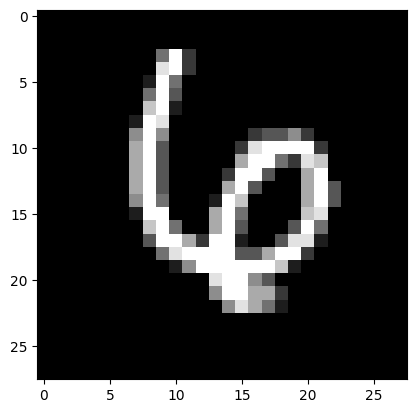

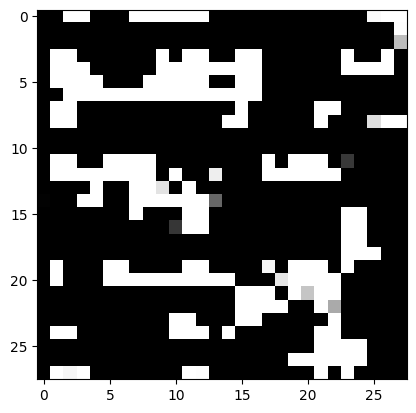

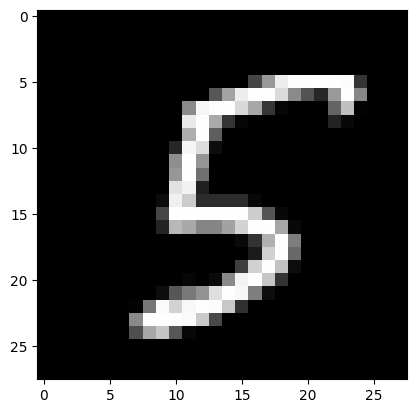

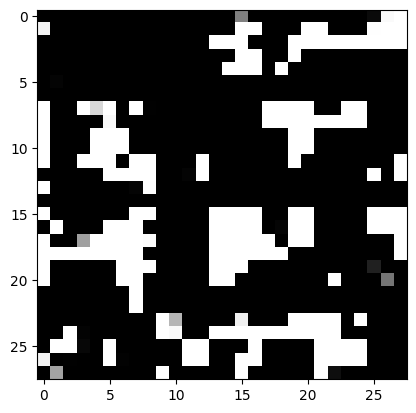

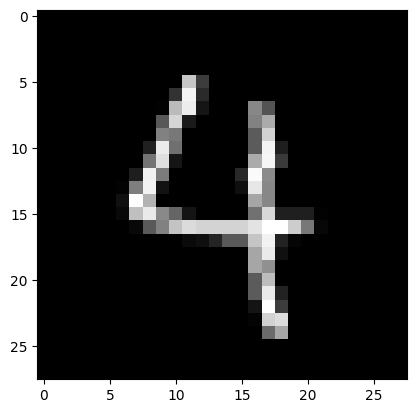

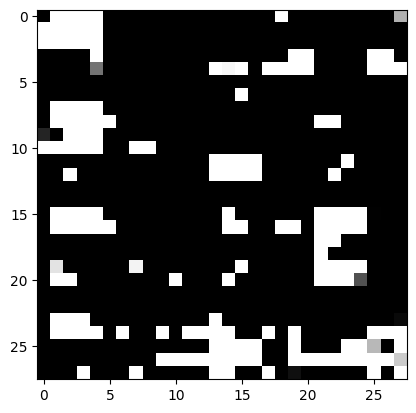

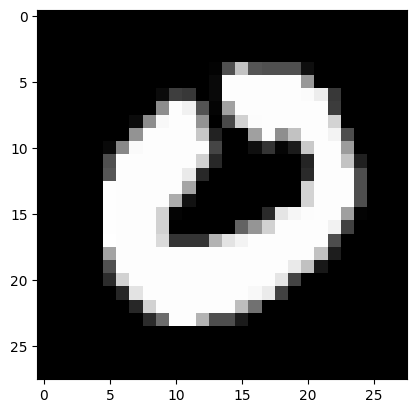

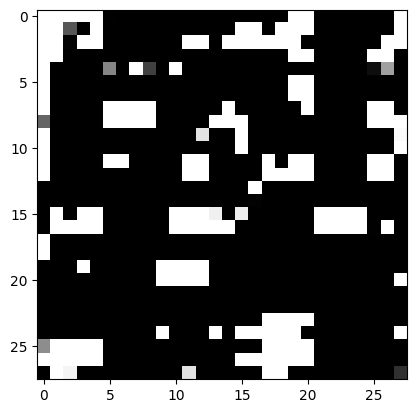

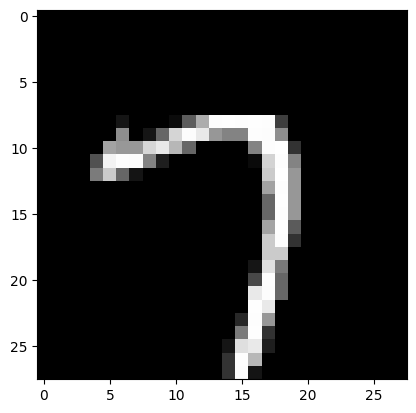

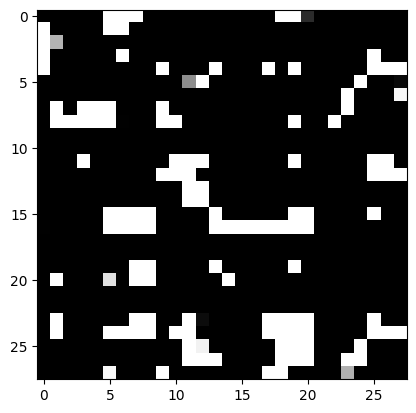

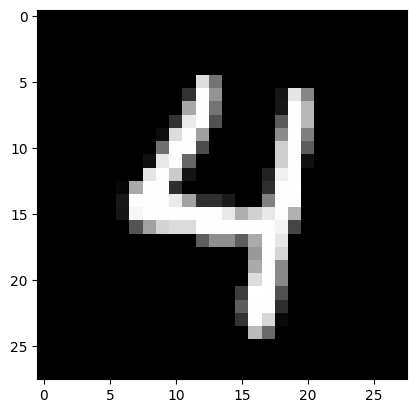

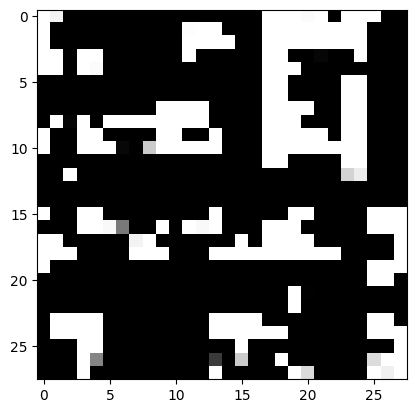

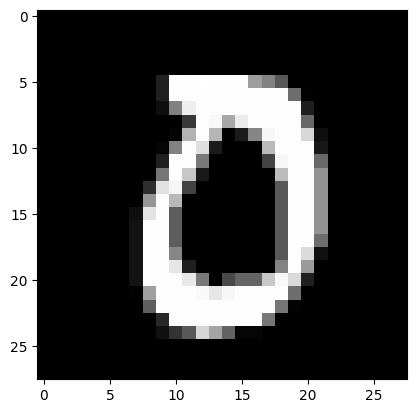

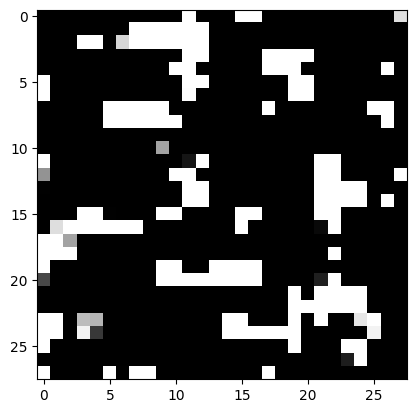

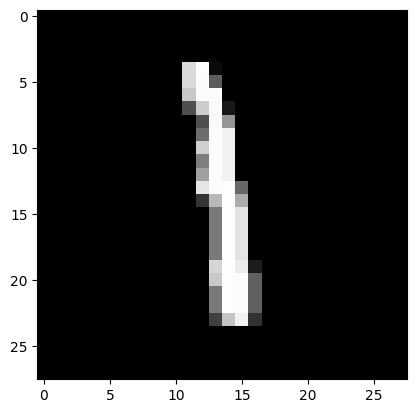

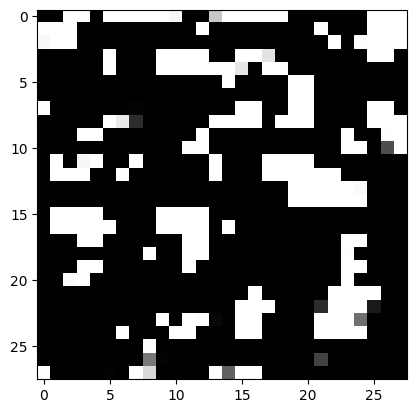

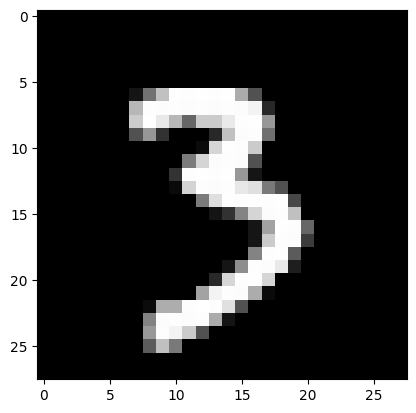

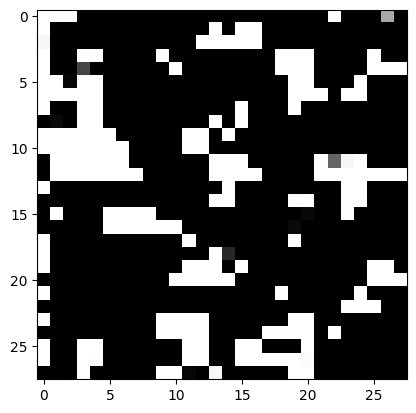

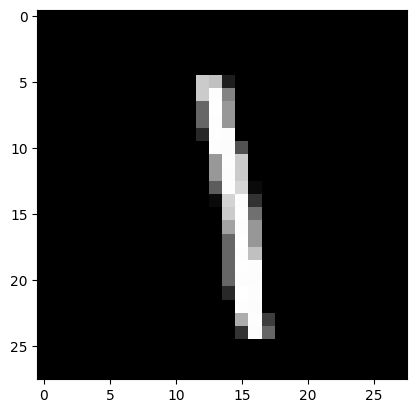

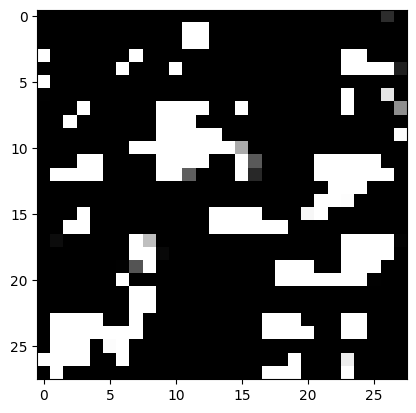

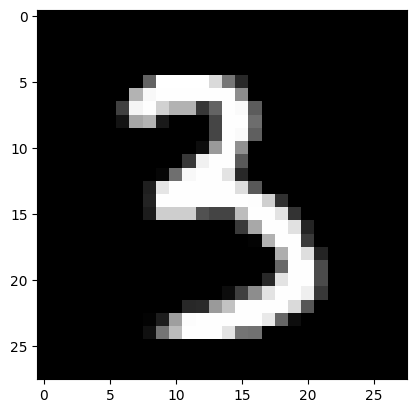

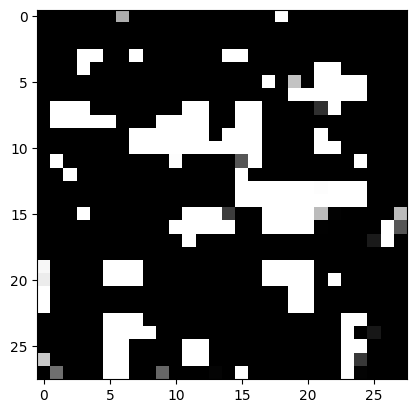

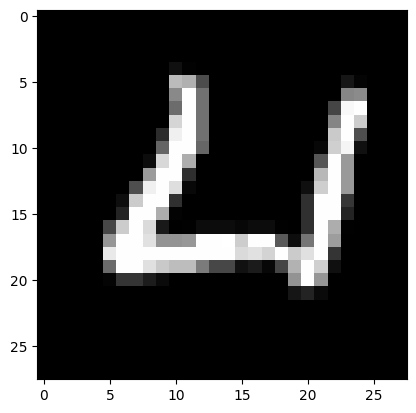

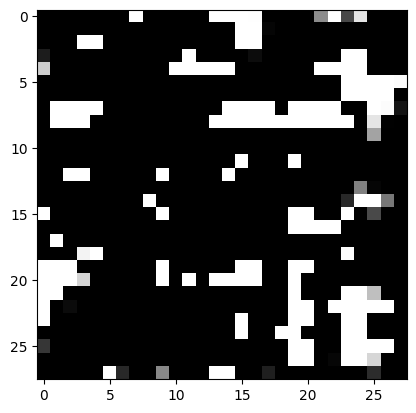

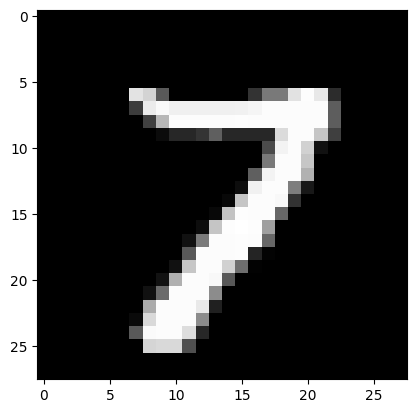

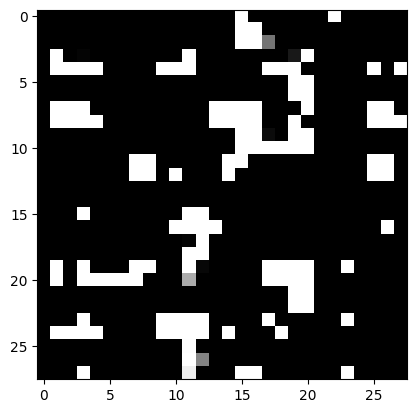

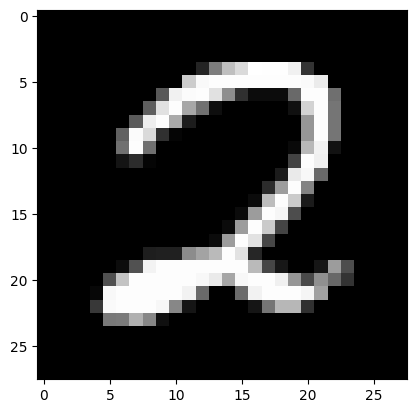

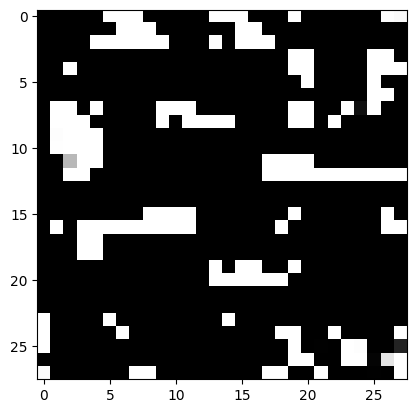

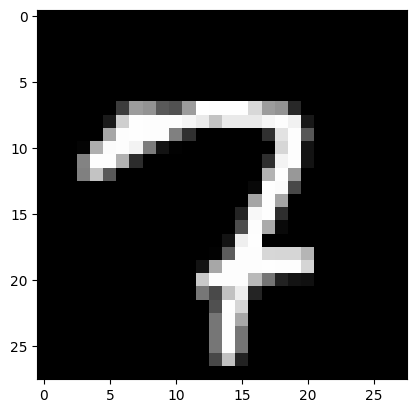

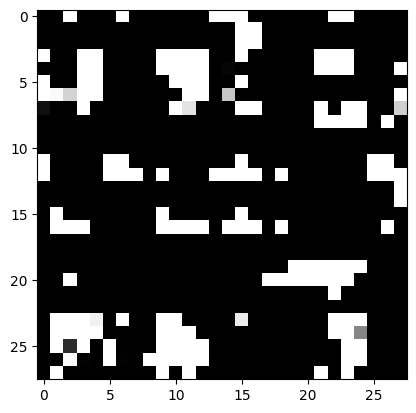

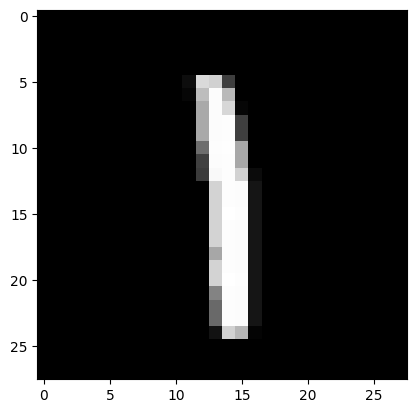

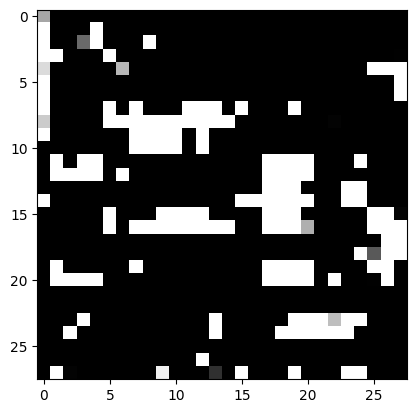

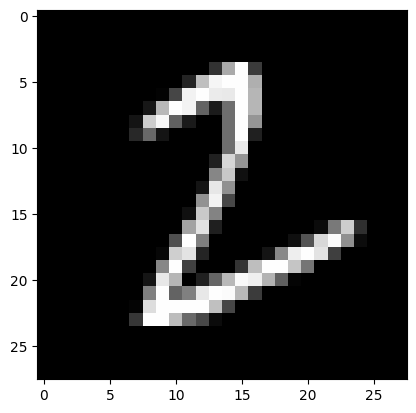

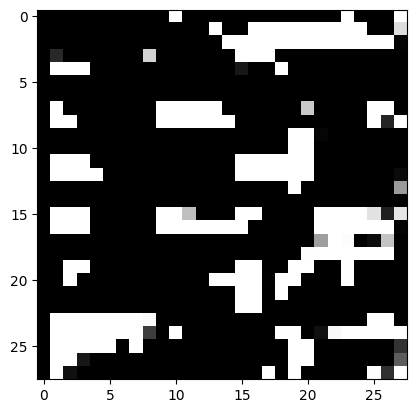

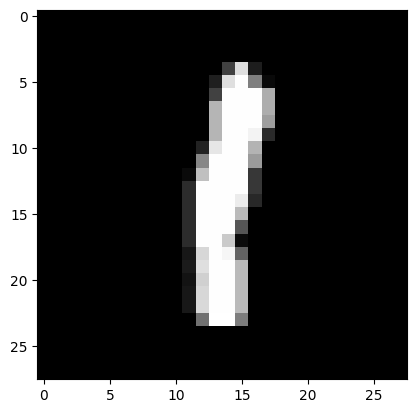

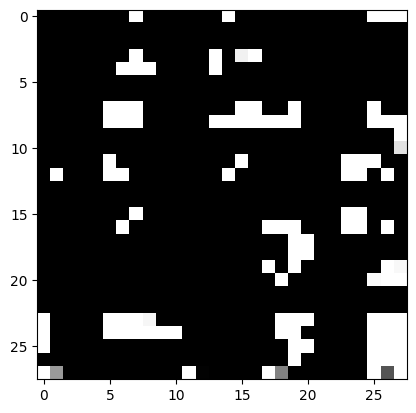

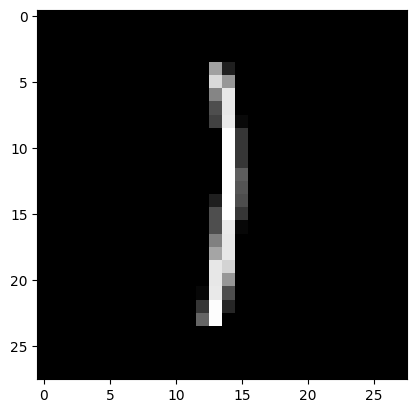

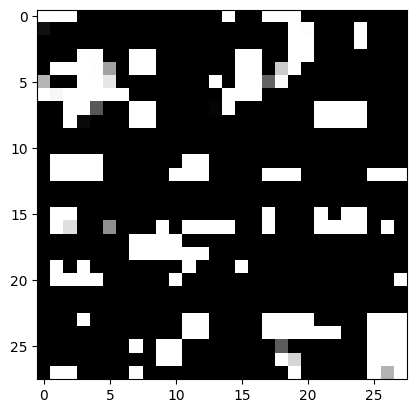

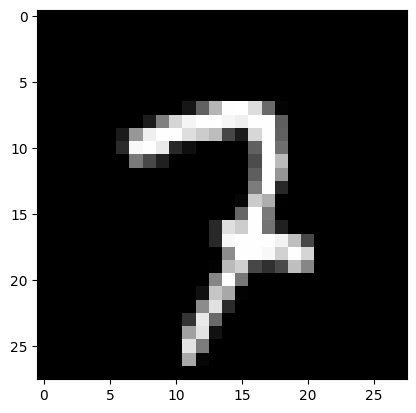

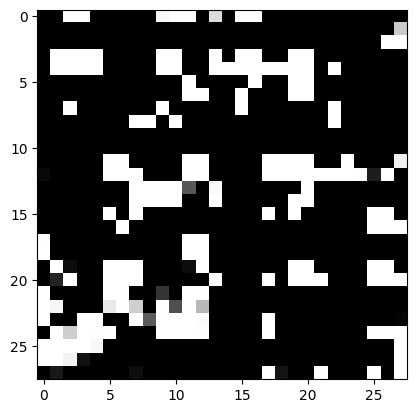

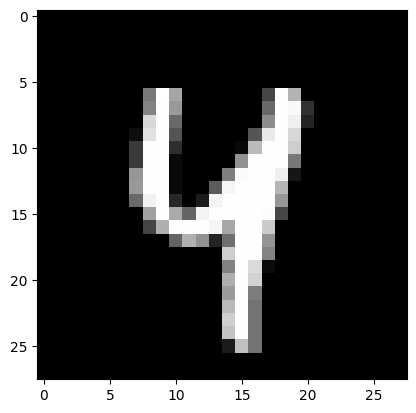

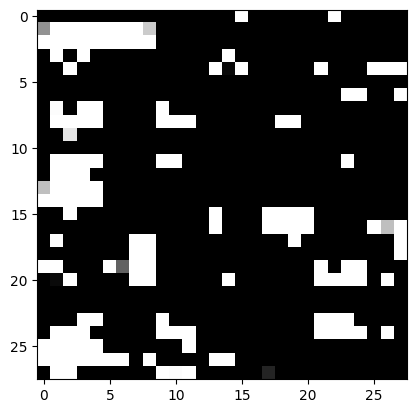

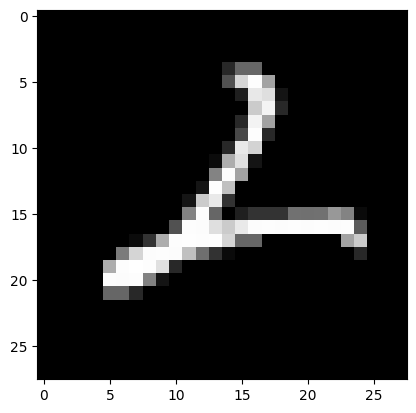

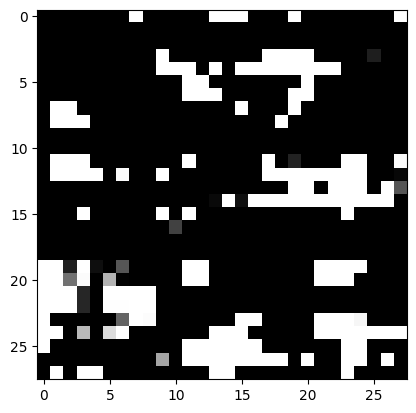

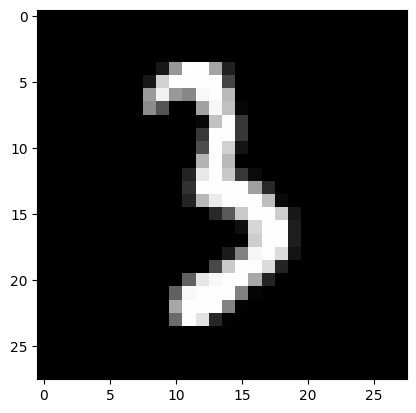

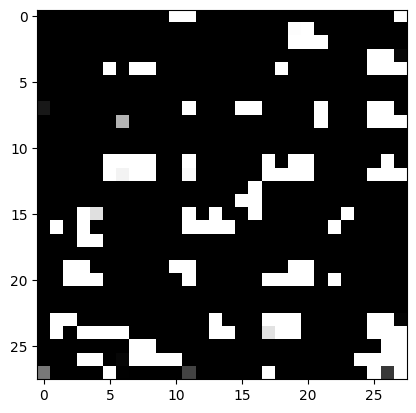

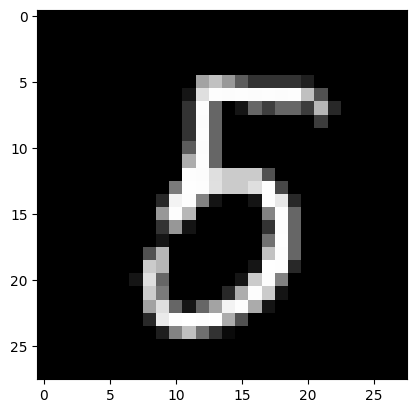

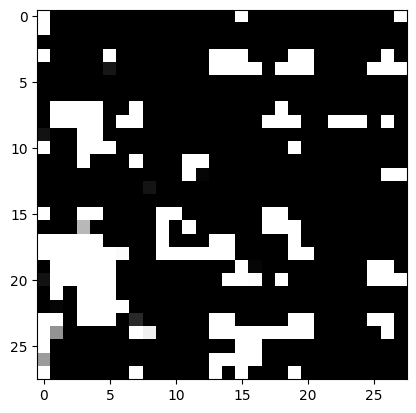

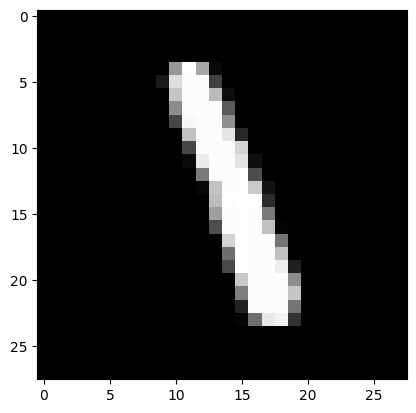

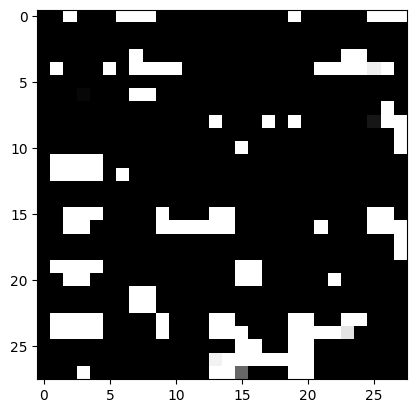

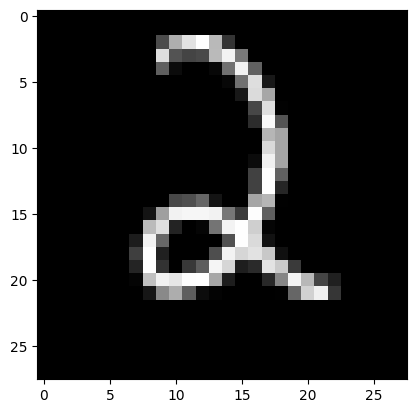

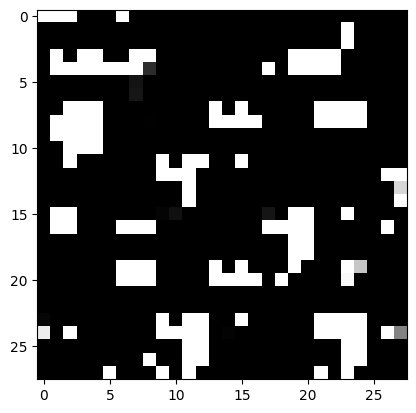

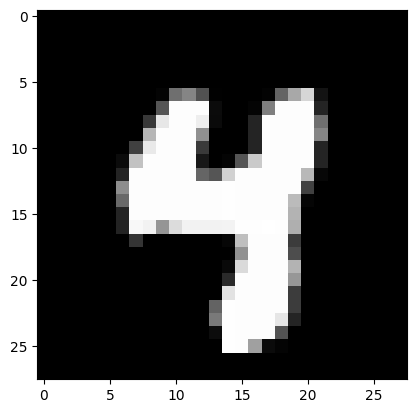

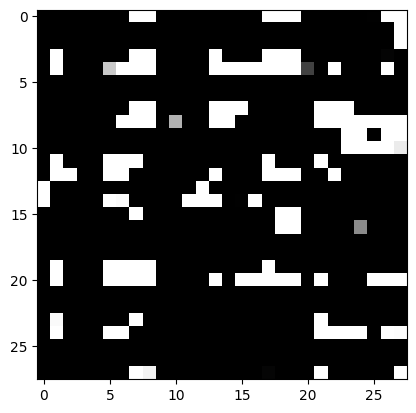

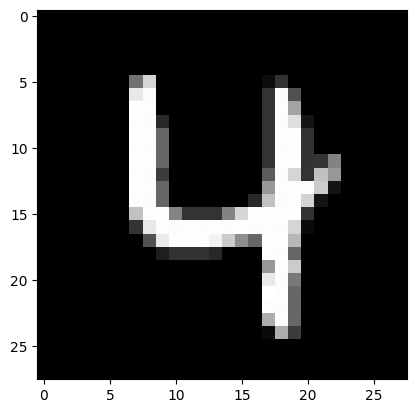

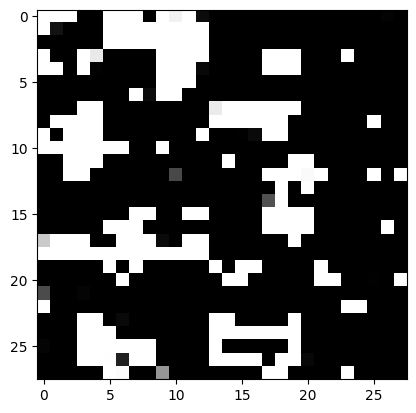

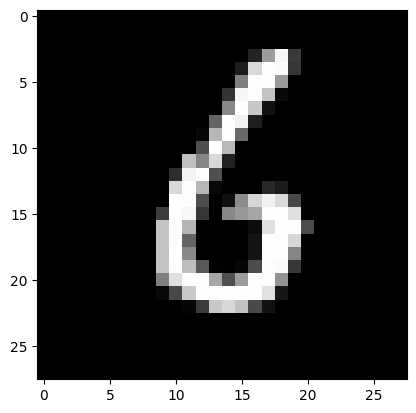

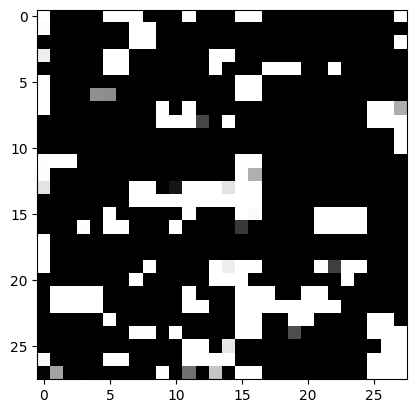

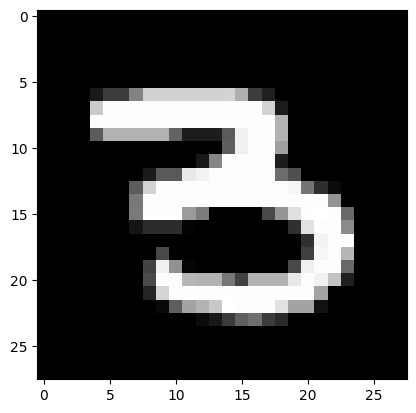

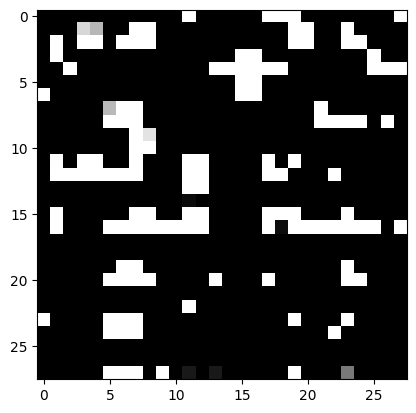

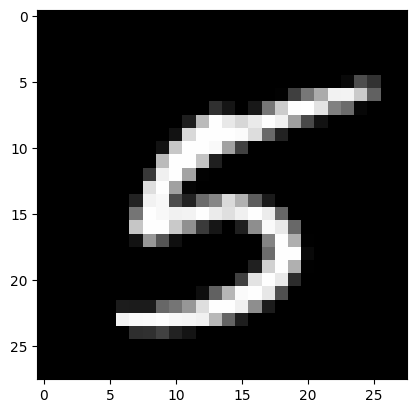

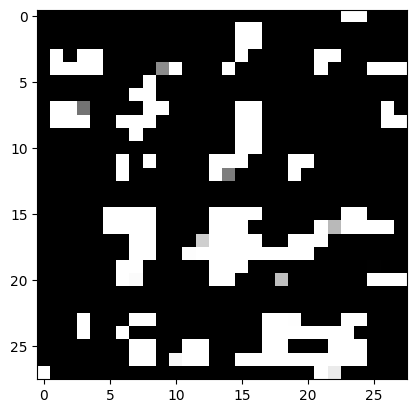

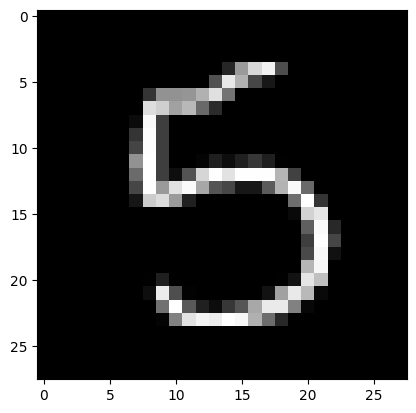

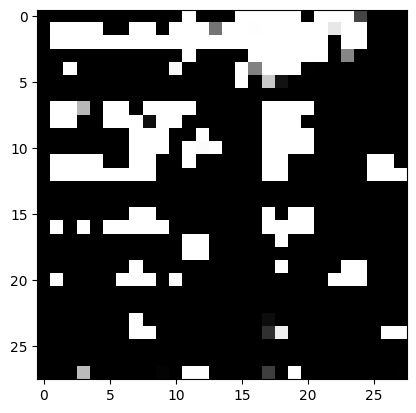

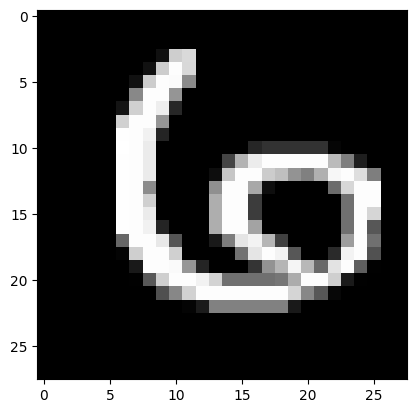

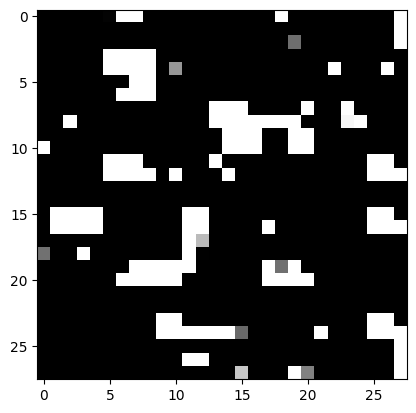

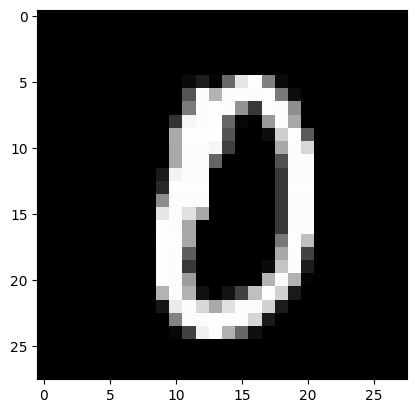

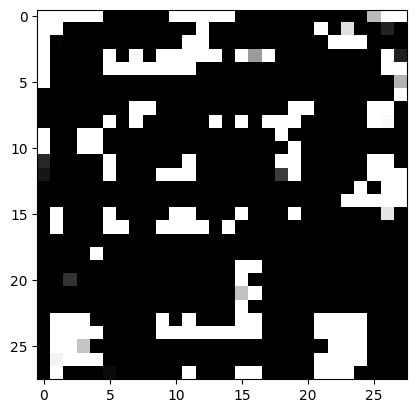

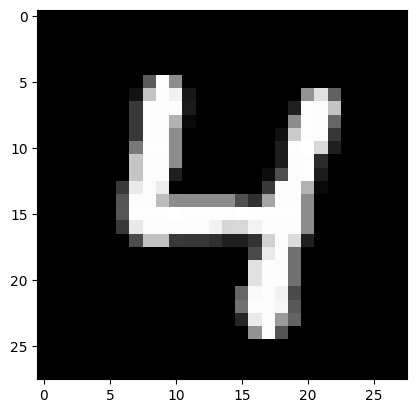

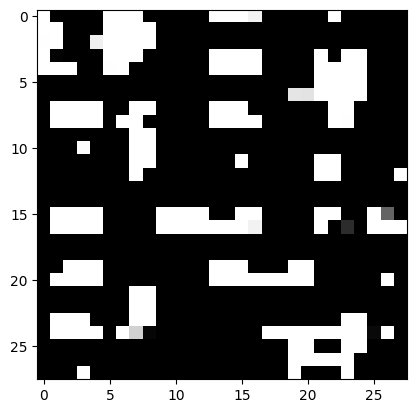

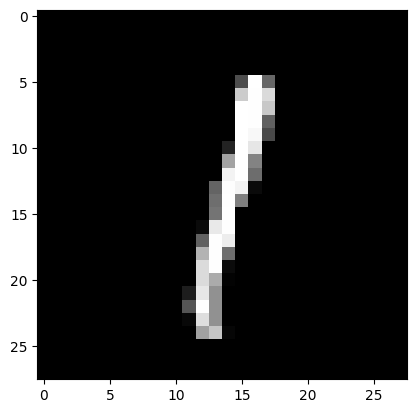

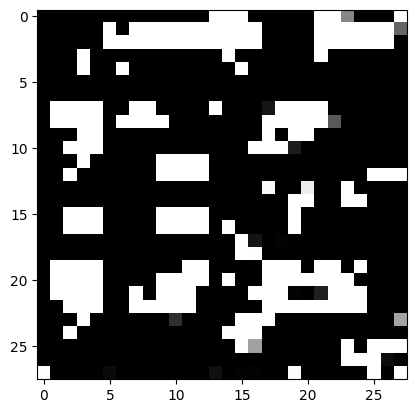

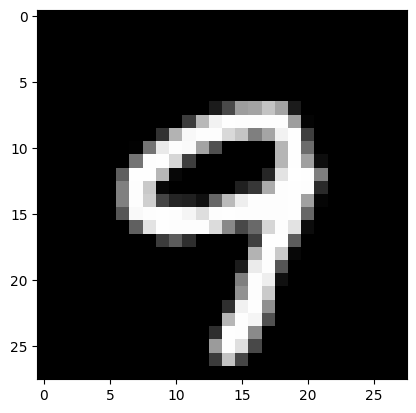

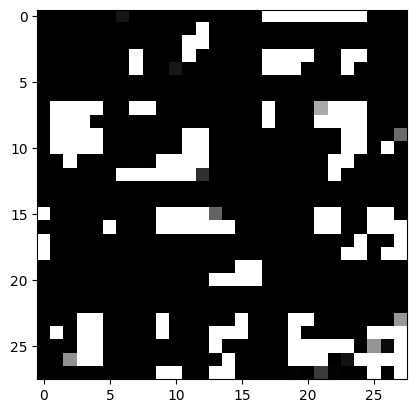

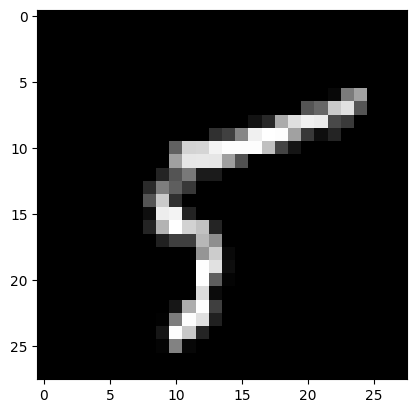

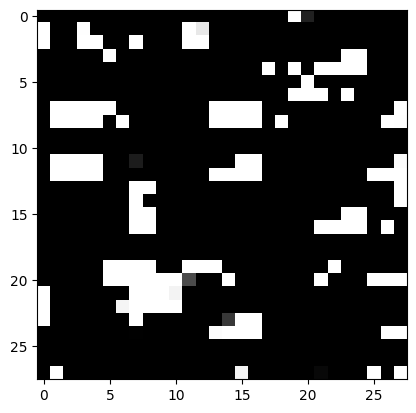

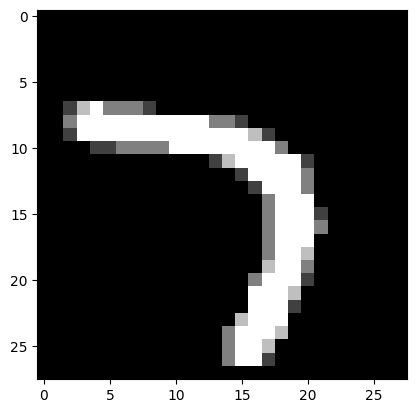

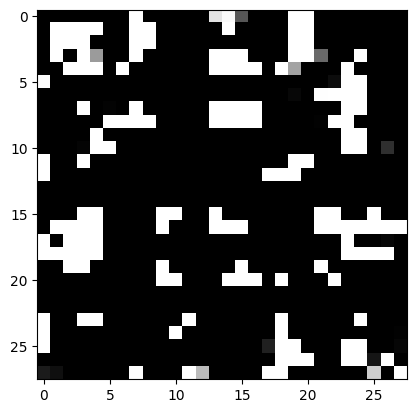

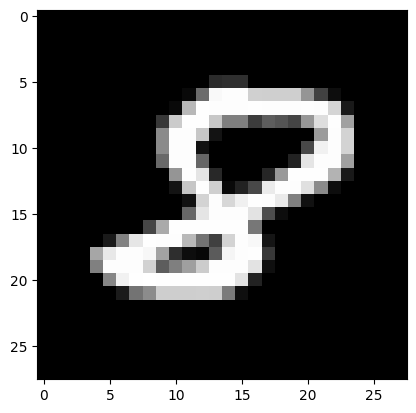

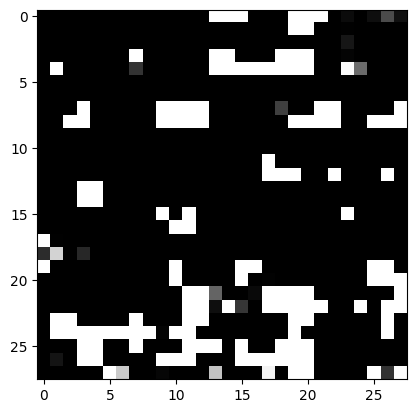

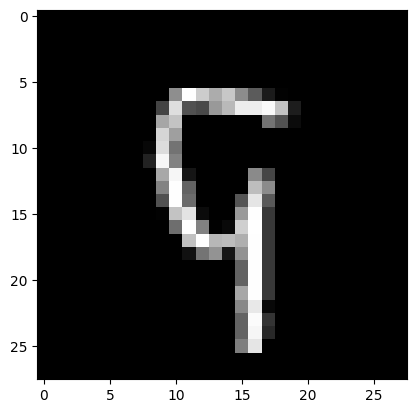

In [46]:
import matplotlib.pyplot as plt
encoder.eval()
decoder.eval()
codebook.eval()

image, _ = next(iter(test_loader))
print(image[1].shape)
for i in range(63):
    z_e = encoder(image[i])
    z_e = real_batch = torch.normal(mean=0, std=1, size=( 2, 7, 7))
    x_hat = decoder(z_e)

    plt.imshow(x_hat.detach().squeeze().numpy(), cmap='gray')
    plt.show()

    plt.imshow(image[i].detach().squeeze().numpy(), cmap='gray')
    plt.show()

Increasing the dimensionality of latent space:

In [ ]:
latent_dim = 8
num_embeddings = 8
embedding_dim = 8
num_epochs = 5
beta = 0.2

encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
codebook = Codebook(num_embeddings, embedding_dim, 0.23)

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(codebook.parameters()), lr=0.1)

loss_arr = []

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    codebook.train()

    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)


        z_e = encoder(x)
        loss_comm, quantized, perplexity, _ = codebook(z_e.detach())
        x_hat = decoder(quantized)

        loss = compute_loss(x, x_hat, loss_comm, beta)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_arr.append(loss.item())
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}")

Epoch 1/5, Batch 0/938, Loss: 1.359756350517273
Epoch 1/5, Batch 100/938, Loss: 0.7017776966094971
Epoch 1/5, Batch 200/938, Loss: 0.7431023120880127
Epoch 1/5, Batch 300/938, Loss: 0.6890615820884705
Epoch 1/5, Batch 400/938, Loss: 0.6997309923171997
Epoch 1/5, Batch 500/938, Loss: 0.656775176525116
Epoch 1/5, Batch 600/938, Loss: 0.7029045224189758
Epoch 1/5, Batch 700/938, Loss: 0.7032108902931213
Epoch 1/5, Batch 800/938, Loss: 0.7548876404762268
Epoch 1/5, Batch 900/938, Loss: 0.7198050022125244
Epoch 2/5, Batch 0/938, Loss: 0.7245373725891113
Epoch 2/5, Batch 100/938, Loss: 0.6902886033058167
Epoch 2/5, Batch 200/938, Loss: 0.7094191908836365
Epoch 2/5, Batch 300/938, Loss: 0.713809072971344
Epoch 2/5, Batch 400/938, Loss: 0.6894019842147827
Epoch 2/5, Batch 500/938, Loss: 0.7022411227226257
Epoch 2/5, Batch 600/938, Loss: 0.6896150708198547
Epoch 2/5, Batch 700/938, Loss: 0.7231341004371643
Epoch 2/5, Batch 800/938, Loss: 0.7260642647743225
Epoch 2/5, Batch 900/938, Loss: 0.7092

In [ ]:
import matplotlib.pyplot as plt
encoder.eval()
decoder.eval()
codebook.eval()

image, _ = next(iter(test_loader))
print(image[1].shape)
for i in range(63):
    z_e = encoder(image[i])
    z_e = real_batch = torch.normal(mean=0, std=1, size=( 2, 7, 7))
    x_hat = decoder(z_e)

    plt.imshow(x_hat.detach().squeeze().numpy(), cmap='gray')
    plt.show()

    plt.imshow(image[i].detach().squeeze().numpy(), cmap='gray')
    plt.show()